#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**


In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [2]:
class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        discrete_x = self.data_discretization(train_features)
        classes_count = Counter(train_classes)
        unique_classes = np.unique(train_classes)

        for unique_class in unique_classes:
            self.priors[unique_class] = classes_count[unique_class] / len(train_classes)
            attributes_dict = {}
            pick_class = train_classes == unique_class

            for i in range(discrete_x.shape[1]):
                values = discrete_x[pick_class, i]
                values_counter = Counter(values)
                values_dict = {}
                for unique_value, count in values_counter.items():
                    values_dict[unique_value] = count / classes_count[unique_class]

                attributes_dict[i] = values_dict
            self.likelihoods[unique_class] = attributes_dict

    @staticmethod
    def data_discretization(data):
        discretized_data = np.zeros_like(data)
        for col in range(data.shape[1]):
            min_val = data[:, col].min()
            max_val = data[:, col].max()
            bins = np.linspace(min_val, max_val, 5)
            discretized_data[:, col] = np.digitize(data[:, col], bins[1:-1], right=False)
        return discretized_data

    def predict(self, sample):
        predictions = {}
        for unique_class, prior in self.priors.items():
            result = prior
            for feature_idx, feature_value in enumerate(sample):
                likelihood = self.likelihoods[unique_class][feature_idx].get(feature_value, 0)
                result *= likelihood
            predictions[unique_class] = result

        return max(predictions, key=predictions.get)

class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        class_counts = Counter(train_classes)
        unique_classes = np.unique(train_classes)

        for unique_class in unique_classes:
            self.priors[unique_class] = class_counts[unique_class] / len(train_classes)
            atributtes_dict = {}
            pick_class = train_classes == unique_class

            for i in range(train_features.shape[1]):
                values = train_features[pick_class, i]
                values_mean = np.mean(values)
                values_std = np.std(values)
                atributtes_dict[i] = [values_mean, values_std]
            self.likelihoods[unique_class] = atributtes_dict

    @staticmethod
    def normal_dist(x, mean, std):
        if std == 0:
            return 0
        else:
          exponent = math.exp(-((x - mean) ** 2) / (2 * (std ** 2)))
          return (1 / (math.sqrt(2 * math.pi) * std)) * exponent

    def predict(self, sample):
        predictions = {}
        for unique_class, prior in self.priors.items():
            result = math.log(prior)
            for feature_idx, feature_value in enumerate(sample):
                mean, std = self.likelihoods[unique_class][feature_idx]
                likelihood = self.normal_dist(feature_value, mean, std)
                result += math.log(likelihood + 1e-9)
            predictions[unique_class] = result

        return max(predictions, key=predictions.get)

In [ ]:
def show_predictions(classifier, x, y):
    prediction_class = []
    for data, true_class in zip(x, y):
        prediction = classifier.predict(data)
        prediction_class.append((prediction, true_class))
    return prediction_class

def calculate_accuracy(classifier, x, y):
    correct = 0
    for sample, true_class in zip(x, y):
      prediction = classifier.predict(sample)
      if prediction == true_class:
          correct += 1
    accuracy = correct / len(y)
    return accuracy * 100

# Eksperymenty

**Dyskretny klasyfikator Bayesa**

In [ ]:
bayes1 = NaiveBayes()
bayes1.build_classifier(x_train, y_train)

discrete_x_test = bayes1.data_discretization(x_test)
predictions_classes = show_predictions(bayes1, discrete_x_test, y_test)
for pred, true_class in predictions_classes:
    print(pred, true_class)

accuracy = calculate_accuracy(bayes1, discrete_x_test, y_test)
print(f"Dokładność dla dyskretnego klasyfikatora Bayesa: {accuracy:.2f}%")

2 1
2 2
2 2
1 1
0 0
2 2
1 1
0 0
0 0
1 1
2 2
0 0
1 1
2 2
2 2
Dokładność dla dyskretnego klasyfikatora Bayesa: 93.33%


**Gaussowski klasyfikator Bayesa**

In [ ]:
bayes2 = GaussianNaiveBayes()
bayes2.build_classifier(x_train, y_train)
predictions_classes = show_predictions(bayes2, x_test, y_test)
for pred, true_class in predictions_classes:
    print(pred, true_class)

accuracy = calculate_accuracy(bayes2, x_test, y_test)
print(f"Dokładność dla gaussowskiego klasyfikatora Bayesa: {accuracy:.2f}%")

1 1
2 2
2 2
1 1
0 0
2 2
1 1
0 0
0 0
1 1
2 2
0 0
1 1
2 2
2 2
Dokładność dla gaussowskiego klasyfikatora Bayesa: 100.00%


**Test klasyfikatorów dla różnego podziału danych**

In [ ]:
random_states = [100, 123, 203, 305, 432, 542]

for state in random_states:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=state)
    bayes_disc = NaiveBayes()
    bayes_disc.build_classifier(x_train, y_train)
    discrete_x_test = bayes_disc.data_discretization(x_test)
    accuracy = calculate_accuracy(bayes_disc, discrete_x_test, y_test)
    print(f"Dyskretny klasyfikator Bayesa: stan: {state} dokładność {accuracy:.2f}%")

    bayes_conti = GaussianNaiveBayes()
    bayes_conti.build_classifier(x_train, y_train)
    predictions_classes = show_predictions(bayes_conti, x_test, y_test)
    accuracy2 = calculate_accuracy(bayes_conti, x_test, y_test)
    print(f"Gaussowski klasyfikator Bayesa: stan: {state} dokładność {accuracy2:.2f}% \n")

Dyskretny klasyfikator Bayesa: stan: 100 dokładność 100.00%
Gaussowski klasyfikator Bayesa: stan: 100 dokładność 100.00% 

Dyskretny klasyfikator Bayesa: stan: 123 dokładność 93.33%
Gaussowski klasyfikator Bayesa: stan: 123 dokładność 100.00% 

Dyskretny klasyfikator Bayesa: stan: 203 dokładność 93.33%
Gaussowski klasyfikator Bayesa: stan: 203 dokładność 86.67% 

Dyskretny klasyfikator Bayesa: stan: 305 dokładność 86.67%
Gaussowski klasyfikator Bayesa: stan: 305 dokładność 93.33% 

Dyskretny klasyfikator Bayesa: stan: 432 dokładność 73.33%
Gaussowski klasyfikator Bayesa: stan: 432 dokładność 100.00% 

Dyskretny klasyfikator Bayesa: stan: 542 dokładność 86.67%
Gaussowski klasyfikator Bayesa: stan: 542 dokładność 93.33% 



$$
\begin{array}{|c|c|c|}
\hline
random\_state & dyskretny & gaussowski  \\
\hline
100 & 100\% & 100\%  \\
\hline
123 & 93,3\% & 100\% \\
\hline
203 & 93,3\% & 86,7\% \\
\hline
305 & 86,7\% & 93,3\% \\
\hline
432 & 73,3\% & 100\% \\
\hline
542 & 86,7\% & 93,3\% \\
\hline
\end{array}
$$

**Test klasyfikatorów dla różnych wielkości zbioru testowego**

In [ ]:
def generate_plot(x, y, n_tries=100, state=None):
  test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  gaussian_accuracies = []
  discrete_accuracies = []

  for ratio in test_sizes:
      gaussian_acc = []
      discrete_acc = []

      for _ in range(n_tries):
          x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=ratio, random_state=state)

          gnb = GaussianNaiveBayes()
          gnb.build_classifier(x_train, y_train)
          gaussian_acc.append(calculate_accuracy(gnb, x_test, y_test))

          dnb = NaiveBayes()
          dnb.build_classifier(x_train, y_train)
          discrete_x_test = NaiveBayes.data_discretization(x_test)
          discrete_acc.append(calculate_accuracy(dnb, discrete_x_test, y_test))

      gaussian_accuracies.append(np.mean(gaussian_acc))
      discrete_accuracies.append(np.mean(discrete_acc))

  plt.plot(test_sizes, discrete_accuracies, label='Dyskretny klasyfikator', marker='s')
  plt.plot(test_sizes, gaussian_accuracies, label='Gaussowski klasyfikator', marker='o')
  plt.title('Dokładność przewidywań w zależności od wielkości zbioru testowego')
  plt.xlabel('Wielkość zbioru testowego')
  plt.ylabel('Dokładność')
  plt.legend()
  plt.grid()
  plt.show()

**Test dla random_state = 123**

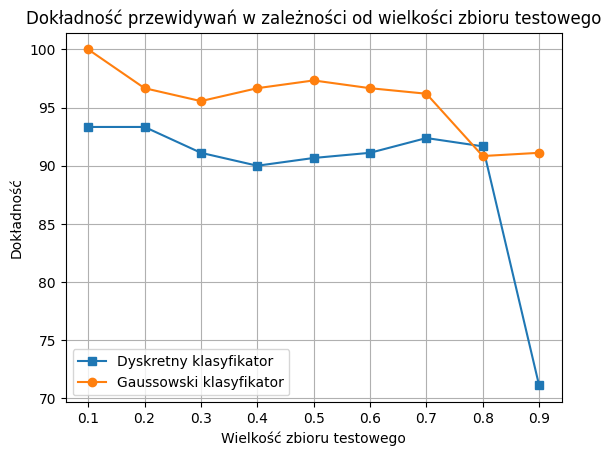

In [ ]:
generate_plot(x, y, state=123)

**Test dla różnych stanów (wynik uśredniony ze 100 prób)**

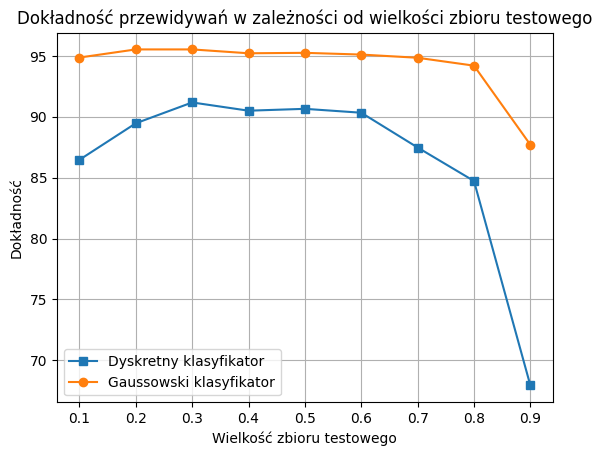

In [ ]:
generate_plot(x, y)

# Wnioski

Klasyfikator gaussowski osiąga lepsze wyniki i większą dokładność w klasyfikacji, ponieważ prawdopodobieństwa są obliczane na podstawie funkcji gęstości rozkładu normalnego, co pozwala na lepsze dopasowanie do ciągłych atrybutów. Klasyfikator dyskretny osiąga gorsze wyniki z uwagi na dyskretyzację danych, która może prowadzić do utraty informacji o subtelnych różnicach między wartościami atrybutów.

Dla małych wielkości zbioru treningowego lepiej radzi sobie gaussowski klasyfikator, ponieważ dane poszczególnych atrybutów przedstawiane są w postaci rozkładu normalnego, a w przypadku klasyfikatora dyskretnego brak konkretnych wartości danego atrybutu dla konkretnej klasy sprawia, że likelihood osiąga wartość 0. To sprawia, że w sytuacji kiedy wszystkie inne wartości atrybutów pasowałyby do danej klasy, brak występowania tej wartości dla jednego atrybutu całkowicie eliminuje możliwość predykcji danej klasy. Z uwagi na ten fakt, klasyfikator dyskretny jest dużo bardziej wrażliwy na małą wielkość zbioru treningowego i gorszą różnorodność danych, przez co osiąga wtedy znacznie mniejszą dokładność.

Dyskretny klasyfikator Bayesa lepiej sprawdzi się, gdy dane są naturalnie dyskretne lub trudne do opisania za pomocą rozkładów ciągłych.
Gaussowski klasyfikator Bayesa daje lepsze rezultaty na ciągłych danych, zwłaszcza jeśli mają one rozkład zbliżony do normalnego.